### Inverse Modelling: Demonstration of parameterisation of structure and history matching
#### Showcasing LoopStructural-Flopy to address Model Structure Uncertainty

This notebook uses a simple example to show how the pinchout of a formation at an unconformity can be included in uncertainty analysis using parameterisation and estimation of parameters and forecasting.


### 1. Project parameters

In [1]:
# TEST
%run ./loop_showcase_functions.ipynb
#load from MODFLOW_tools (clone repo https://github.com/JimMcCallum/MODFLOW_Tools)
%run ../../MODFLOW_Tools/modelling_routines/modelling_routines.ipynb
%run ../../MODFLOW_Tools/meshing_routines/meshing_routines.ipynb
%run ../../MODFLOW_Tools/geomodel_routines/geomodel_routines.ipynb
%run ../../MODFLOW_Tools/loop2flopy/loop2flopy.ipynb
%run ../../MODFLOW_Tools/plotting_routines_USG/plotting_routines.ipynb

C:\Users\19904604\AppData\Local\Temp\ipykernel_24324\3209728366.py:21: DeprecationWarning: GeoPandas is set to use PyGEOS over Shapely. PyGEOS support is deprecatedand will be removed in GeoPandas 1.0, released in the Q1 of 2024. Please migrate to Shapely 2.0 (https://geopandas.org/en/stable/docs/user_guide/pygeos_to_shapely.html).
  import geopandas as gpd


Modelling routines loaded!
Meshing routines loaded!
Geomodel routines loaded!
loop2flopy routines loaded!
Plotting routines loaded!


In [53]:
P = Project('showcase', boundingbox = [0, 6000, 0, 6000, -500, 0]) # (x0, x1, y0, y1, z0, z1)

# ------------- DISCRETISATION PARAMETERS -----------------------#
P.triExeName = '../exe/triangle.exe'
P.workspace = '../modelfiles/'
P.crs = "epsg:28350" # Put in coordinate reference
P.xypumpbores = [(2000, 2000), (2500, 2000), (2000, 2500), (2500, 2500),] 
P.idpumpbores = ['P0','P1','P2','P3'] 
P.xyobsbores = [(1500,1000), (2500, 5000), (4000, 3000), (1500, 3500), (4500,4500)] 
P.idobsbores = ['OB1', 'OB2', 'OB3', 'OB4', 'OB5'] 
P.nobs = len(P.xyobsbores)
P.nzobs = 3
P.npump = len(P.xypumpbores)

P.r = 40        # refining factor for model boundary. High r has refined edges
P.w = 100      # Interior boundary
P.boundmaxtri = 50000 
P.modelmaxtri = 50000 # 10000 for ref
P.angle = 32   # minimum triangle angles

P.radius1 = 100 # radius of inner circle around pumping bores
P.radius2 = 200 # radius of outer circle around pumping bores
P.boremaxtri = 100000

#P.geo_bores = ['P1', 'P2', 'P3', 'P4']
#P.geo_coords=[(500,500), (1600, 2800), (5500,5500), (2800,1600)]

# ------------- FLOW MODEL PARAMETERS -----------------------#
P.mfexe_name = '../exe/mf6.exe'

P.nlg = 4    # number of geological layers
P.nls = 3 # Number sublayers for conformable
P.geo_pl = 3 # Which geological layer pumping from (zero-based)

P.hk = [10, 2, 0.1, 5] # [1, 0.1, 5, 0.1] 
P.vk = [i/10 for i in P.hk]
P.ss = [0.00005, 0.00005, 0.00005, 0.00005]
P.sy = [0.1, 0.1, 0.1, 0.1]

P.rch = 0.4/365 # 0.0027 m/d
P.strt = -20.

P.chfunc = lambda x,z: -(0.005*x) - (z * 0.02)-20 # horizontal gradient of 0.01 and vertical gradient of 0.02
P.xt3d = True

past_years = 2
P.nts_past = past_years * 6
P.tdis_past = [(past_years * 365, P.nts_past, 1.2)] # period length, number of timesteps, tsmult
P.qwell_past = -2000 #m3/d 

future_years = 5
P.nts_future = future_years * 6
P.tdis_future = [(future_years * 365, P.nts_future, 1.2)] # period length, number of timesteps, tsmult
P.qwell_future = -5000 #m3/d 

#P.zobs = [-50, -100, -200]
   
vtk_workspace = '../vtk_files'
if not os.path.isdir(vtk_workspace):
    os.makedirs(workspace, exist_ok=True)

### 2. Meshing

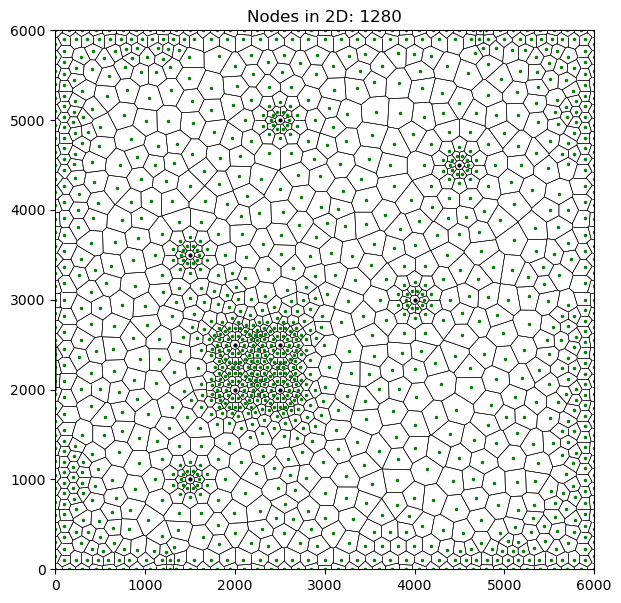

In [54]:
P.cell2dvor, P.xcycvor, P.verticesvor, P.vor, vornodes = createcell2d(P, grid = 'vor', fault = False)      
plot_cell2d_vor(P, xlim = [P.x0, P.x1], ylim = [P.y0, P.y1]) #xlim = [0, 3500], ylim = [0, 3500]

P.nlv  = 30  
P.delx, P.dely = 40, 40
P.ncol, P.nrow = int((P.x1 - P.x0) / P.delx), int((P.y1 - P.y0) / P.dely)
P.cell2dcar, P.xcyccar, P.verticescar, P.sg = createcell2d(P, grid = 'car', fault = False)    

### 3. Geological model (Reference)

In [55]:
P.control_points = ([])
data = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "inverse_example")
strat = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "strat")
P.data, P.strat = prepare_geomodel_loopshowcase(P, data, strat, include_fault = False)     # Prepare geomodel inputs
P.geomodel = create_geomodel_loopshowcase(P, include_fault = False) # Make geomodel

{'upper': 0, 'upper_unconformity': 1, 'lower': 2}


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


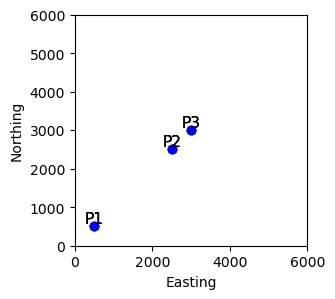

In [56]:
P.data
P.geomodel.feature_names()
plot_bores(P)

### 4. Flow model (Reference)

In [57]:
# Initiate REFERENCE
R = Model('ref', P, plan = 'vor', transect = 'con') 
R.create_lith_dis_arrays(P)     # Create lithology and discretisation arrays (DIS)

Creating lithology and discretisation arrays for  ref  ...
Time taken =  2.255074


In [58]:
P.wel_screens = []
for n in range(len(P.xypumpbores)):
    wel_icpl, wel_coords = find_cell_disv(P.xypumpbores[n][0], P.xypumpbores[n][1], R.xcyc)
    if P.geo_pl == 0:
        wel_top = R.top[wel_icpl]  
    else:   
        wel_top = R.botm[(P.geo_pl)* P.nls-1, wel_icpl]
    wel_bot = R.botm[(P.geo_pl + 1) * P.nls-1, wel_icpl]   
    print(wel_coords, wel_top, wel_bot)
    P.wel_screens.append((wel_top, wel_bot))
    
P.zobs = np.zeros((P.nobs,P.nzobs))
for n in range(len(P.xyobsbores)):
    obs_icpl, obs_coords = find_cell_disv(P.xyobsbores[n][0], P.xyobsbores[n][1], R.xcyc) # Cell id in plan
    for m in range(3): # For the top three geological layers
        if m == 0:
            lay_top = R.top[obs_icpl]  
        else:   
            lay_top = R.botm[(m)* P.nls-1, obs_icpl]
        lay_bot = R.botm[(m + 1) * P.nls-1, obs_icpl]   
        obsz = lay_bot + (lay_top-lay_bot)/2
        P.zobs[n][m] = obsz
P.zobs

(2000.0, 2000.0) -288.0 -500.0
(2500.0, 2000.0) -266.0 -500.0
(2000.0, 2500.0) -266.0 -500.0
(2500.0, 2500.0) -250.0 -500.0


array([[ -25., -162., -326.],
       [ -25.,  -50., -101.],
       [ -25.,  -60., -121.],
       [ -25.,  -99., -199.],
       [ -25.,  -50.,  -73.]])

In [59]:
R.create_prop_arrays(P)         # Create property arrays (NPF)
R.create_flow_package_arrays(P) # Create flow packages (CHD, RCH, IC, WEL, OBS)
print(R.modelname, ' has ', R.nnodes_div, ' nodes.')

Creating property arrays for  ref  ...
Time taken =  0.01271
Adding flow packages to  ref  ...
Time taken =  0.865381
ref  has  15360  nodes.


In [60]:
R.gwf, R.head_ss, R.obs_ss, R.runtime_ss = R.write_run_model(P, period = 'Steady', ic_array = P.strt)   # 3 hours to run!

Writing simulation and gwf for  ref  ...
ref
Running simulation for  ref  ...
Period =  Steady 
Model success =  True
run_time =  16.888617


In [61]:
R.gwf, R.head_present, R.obs_present, R.runtime_past = R.write_run_model(P, period = 'Past', ic_array = R.head_ss)

Writing simulation and gwf for  ref  ...
ref
Running simulation for  ref  ...
Period =  Past 
Model success =  True
run_time =  56.061348


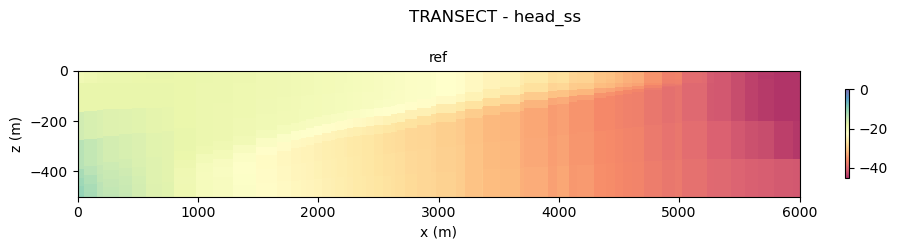

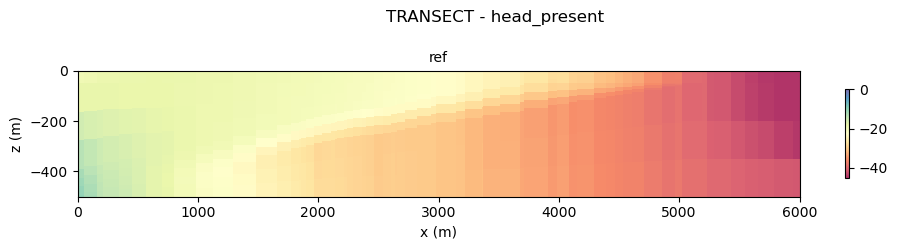

In [62]:
multiplot_prop_transect(P, models = [R], array = 'head_ss', 
                        X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1,
                        vmin = -45, vmax = 0)
multiplot_prop_transect(P, models = [R], array = 'head_present', 
                        X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1,
                        vmin = -45, vmax = 0)

In [63]:
R.gwf, R.head_future, R.obs_future, R.runtime_future = R.write_run_model(P, period = 'Future', ic_array = R.head_present)

Writing simulation and gwf for  ref  ...
ref
Running simulation for  ref  ...
Period =  Future 
Model success =  True
run_time =  112.054239


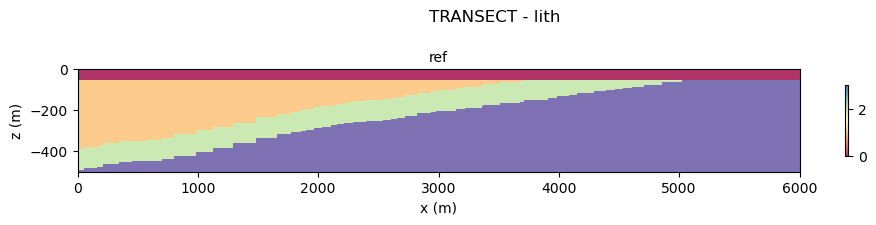

In [64]:
multiplot_vgrid_transect(P, models = [R], array = 'lith', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1) 

In [65]:
#f = os.path.join(vtk_workspace, "test", R.modelname)
#R.gwf.export(f, fmt="vtk")

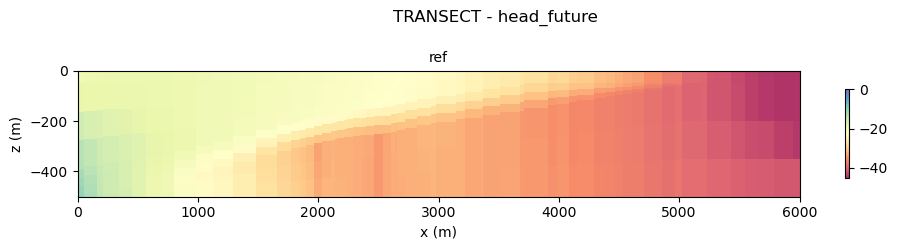

In [66]:
#plot_flow_features(P, [R])
#multiplot_prop_transect(P, models = [R], array = 'logk11', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1)
multiplot_prop_transect(P, models = [R], array = 'head_future', 
                        X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1, vmin = -45, vmax = 0)


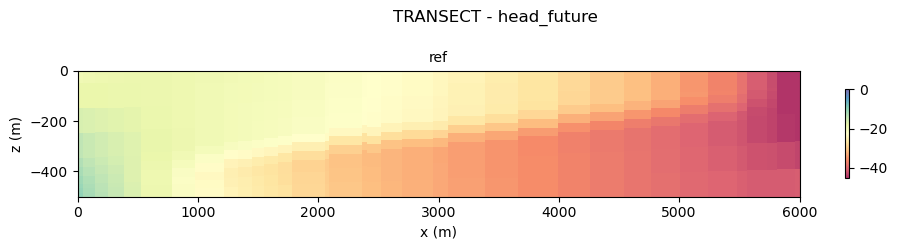

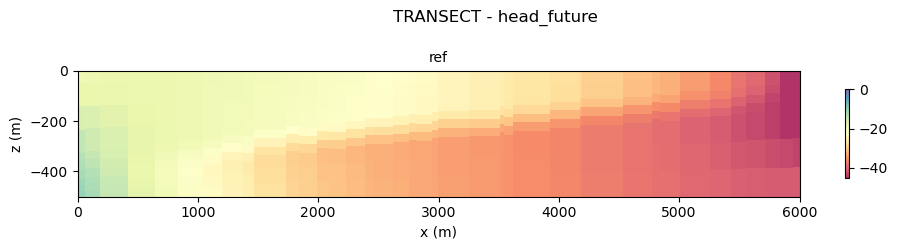

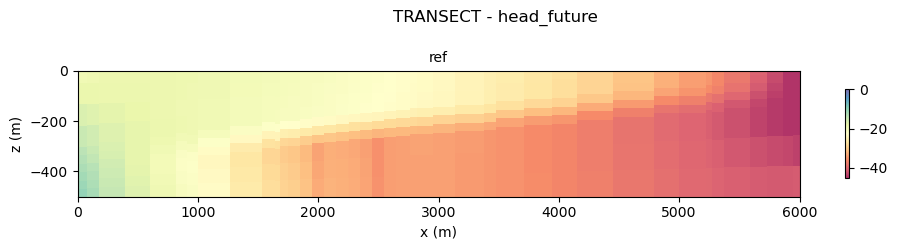

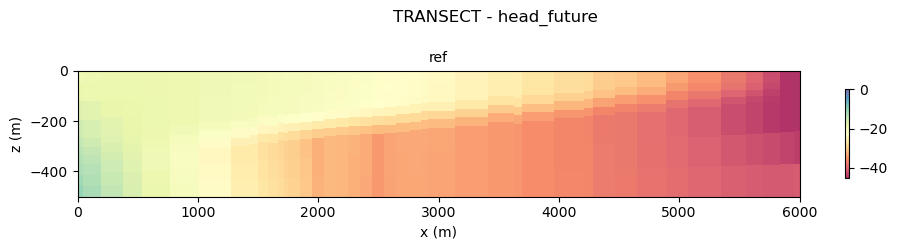

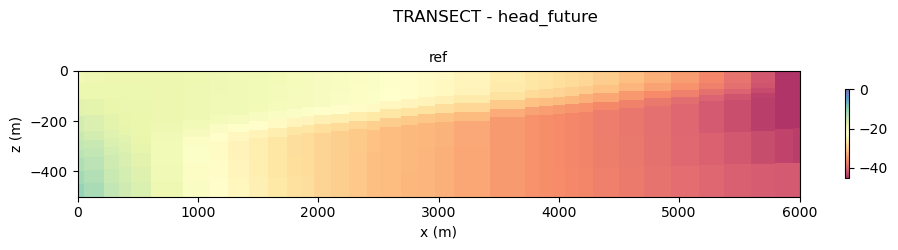

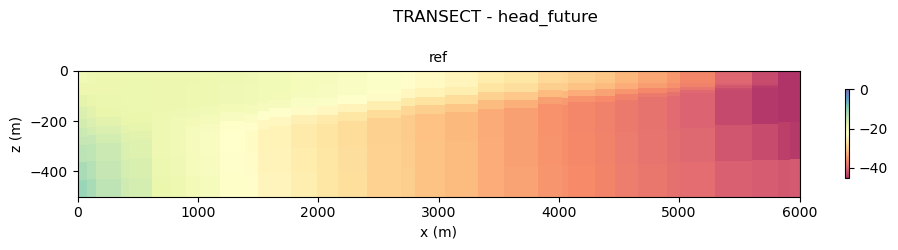

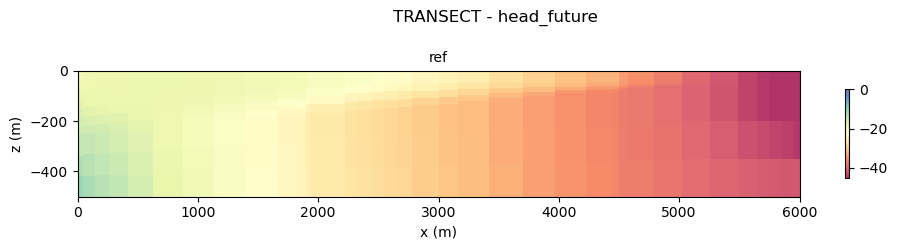

In [67]:
y_ = [1000,1500,2000,2500,3000,4000,5000]
for y in y_:
    multiplot_prop_transect(P, models=[R], array ='head_future',X0=P.x0, Y0=y, X1=P.x1, Y1=y, vmin = -45, vmax = 0)

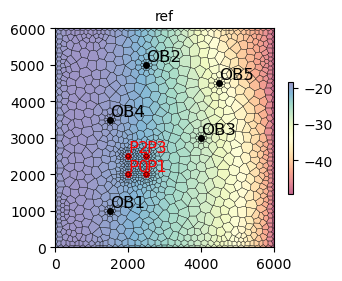

In [68]:
plot_bylayer(P, models = [R], layer = 1)#, vmin = -20, vmax = 5) 

In [69]:
#multiplot_prop_plan(P, models = [R], array = 'k11', layer = 3)#, vmin = None, vmax = None):   # array needs to be a string of a property eg. 'k11', 'logk11'  


### 14. Create "truth" observations and plot observations

In [1]:
R.ref_steady  = process_obs_steady(P, R)
R.ref_past    = process_obs_past(P, R)
R.ref_future  = process_obs_future(P, R)

NameError: name 'process_obs_steady' is not defined

In [71]:
if not os.path.isdir('../results'):
    os.makedirs(workspace, exist_ok=True)
    
fname = '../results/ref_ss.pkl'
pickle.dump(R.ref_steady, open(os.path.join(P.workspace, fname),'wb'))
fname = '../results/ref_past.pkl'
pickle.dump(R.ref_past, open(os.path.join(P.workspace, fname),'wb'))
fname = '../results/ref_future.pkl'
pickle.dump(R.ref_future, open(os.path.join(P.workspace, fname),'wb'))

In [72]:
# Get times
csv_file = os.path.join(P.workspace, R.modelname + "_past.csv")
data_set = pd.read_csv(csv_file, header=0)
df = pd.DataFrame(data_set)
times_past = df.iloc[:,0]/365

csv_file = os.path.join(P.workspace, R.modelname + "_future.csv")
data_set = pd.read_csv(csv_file, header=0)
df = pd.DataFrame(data_set)
times_future = df.iloc[:,0]/365+2

Text(0, 0.5, 'Head (m)')

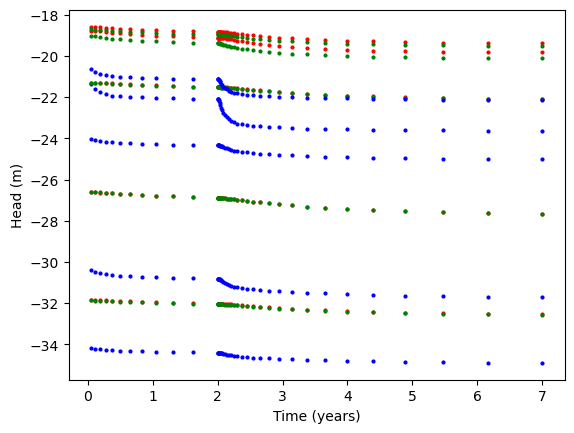

In [73]:
colors = ['red','green','blue']
R.ref_future.shape
for j in range(P.nobs):
    for i in range(P.nzobs):
        plt.plot(times_past, R.ref_past[j][i],'o', ms = 2, color = colors[i])
        plt.plot(times_future, R.ref_future[j][i],'o', ms = 2, color = colors[i])
plt.xlabel('Time (years)')
plt.ylabel('Head (m)')

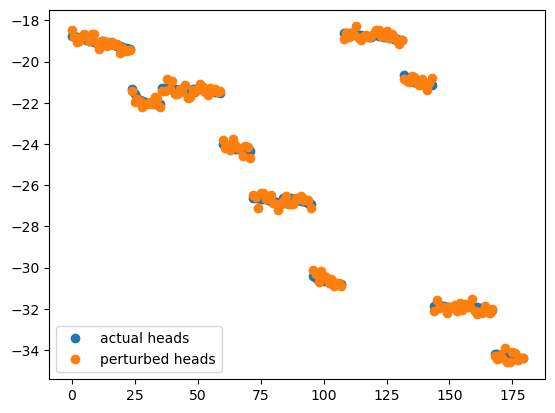

In [74]:
# CREATE SYNTHETIC OBSERVATIONS BY PERTURBING ACTUAL HEADS
err = 0.2
hobs_ref = np.copy(R.ref_past)    
for i in range(P.nobs):
    for j in range(P.nzobs):
        for k in range(hobs_ref.shape[2]):
            hobs_ref[i][j][k] += np.random.normal(0.,err) # Perturb samples either side of measurement
plt.plot(R.ref_past.flatten(), 'o', label = 'actual heads')
plt.plot(hobs_ref.flatten(),'o', label = 'perturbed heads')
plt.legend()

### 15. Set up Markov Chain Monte Carlo (MCMC)

#### Define statistics of parameters

In [75]:
print(P.hk, P.vk)
print(logfunc(P.hk), logfunc(P.vk))

[10, 2, 0.1, 5] [1.0, 0.2, 0.01, 0.5]
[ 1.       0.30103 -1.       0.69897] [ 0.      -0.69897 -2.      -0.30103]


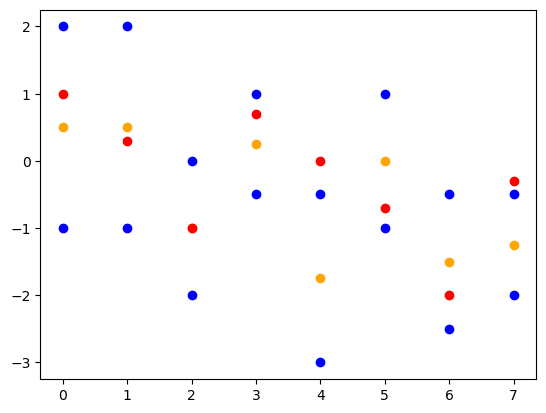

In [76]:
k_min = [-1, -1, -2, -0.5,   -3,  1, -2.5, -2]
k_max = [2,   2,  0,    1, -0.5, -1, -0.5, -0.5]
k_mean = [(k_max[i] - k_min[i])/2 + k_min[i] for i in range(8)]
plt.plot(np.linspace(0,7,8), k_min, 'o', color = 'blue')
plt.plot(np.linspace(0,7,8), k_max, 'o', color = 'blue')
plt.plot(np.linspace(0,7,8), k_mean, 'o', color = 'orange')
plt.plot(np.linspace(0,7,8), logfunc(P.hk + P.vk), 'o', color = 'red')

In [77]:
def Likelihood(obs,mod,err):
    return(np.sum(-(obs-mod)**2/(2*err**2)))

from DREAM import *

Unif = [] # True = Uniform, False = Normal
Log = []  # ?? Just put False
Mean = []
Width = []  # for uniform distributon the range,  for normal, the standard deviation
Min = []
Max = []

###K values
for i in range(len(P.hk)):
    Unif.append(True) # True if uniform, False if normal
    Log.append(False) # Ignore
    Mean.append(k_mean[i])
    Width.append(k_mean[i] - k_min[i])
    Min.append(k_min[i]) 
    Max.append(k_max[i]) 
    
for i in range(len(P.vk)):
    Unif.append(True) # True if uniform, False if normal
    Log.append(False) # Ignore
    Mean.append(k_mean[i+4])
    Width.append(k_mean[i+4] - k_min[i+4])
    Min.append(k_min[i+4]) 
    Max.append(k_max[i+4])
    
for i in range(3): # 1e-4 to 1e-6 # Botom 3 layers
    Unif.append(True) # True if uniform, False if normal
    Log.append(True) # Ignore
    Mean.append(-4.5)
    Width.append(0.5)
    Min.append(-5) 
    Max.append(-4)
    
#Sy top geo layer #0.05 - 0.2
Unif.append(True)
Log.append(False)
Mean.append(0.125)
Width.append(0.125/2)
Min.append(0.05)
Max.append(0.2)

#Control points z value
Unif.append(True)
Log.append(False)
Mean.append(-125)
Width.append(125)
Min.append(-250)
Max.append(0)

#### Set up DREAM and define "run model" function

In [78]:
## DREAM for Steady State
err = 0.2
nchains = 5     #number of parallel chains 
npars = len(Mean)  #number of parameters
nburn = 20 
nsamples = 100

D = DREAM(nchains, npars, nburn = nburn, npairs = 1) #nburn is burn in perion, npairs defines how you sample
D.par_set(Log,Unif,Mean,Width,Min,Max) #initialise the class
D.set_CR(ncr=3)  #crossover testing thingy. Use 3
D.k = 1  # Number of things to try each chain. Numbers other than 1 can give weird results for some models

#### Run first sample to get first likelihood

In [79]:
data = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "pinchout_example")
strat = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "strat")
    
# Include this here when ignoring structural parameters
#P.control_points = (['CP1', 'control', 3000, 3000, -100, -200, 'c', 'lower', np.nan, np.nan, np.nan],) 
#P.data, P.strat = prepare_geomodel_loopshowcase(P, data, strat, include_fault = False)   # Prepare geomodel inputs
#P.geomodel = create_geomodel_loopshowcase(P, include_fault = False) # Make geomodel

In [80]:
def update_model(P, loghk0, loghk1, loghk2, loghk3, logvk0, logvk1, logvk2, logvk3, 
                 logss1, logss2, logss3, sy0, cp):
    del P.hk
    del P.vk
    del P.ss
    del P.sy
    P.hk = [10**loghk0, 10**loghk1, 10**loghk2, 10**loghk3] #[1, 0.1, 10, 0.1] 
    P.vk = [10**logvk0, 10**logvk1, 10**logvk2, 10**logvk3] #[i/10 for i in P.hk]
    P.ss = [0.00005, 10**logss1, 10**logss2, 10**logss3]
    P.sy = [sy0, 0.1, 0.1,0.1]#[sy0, 0.1, 0.1, 0.1]
    P.control_points = (['CP1', 'control', 3000, 3000, cp, -200, 'c', 'lower', np.nan, np.nan, np.nan],) 
    P.data, P.strat = prepare_geomodel_loopshowcase(P, data, strat, include_fault = False)   # Prepare geomodel inputs
    P.geomodel = create_geomodel_loopshowcase(P, include_fault = False) # Make geomodel
    M = Model('run', P, plan = 'vor', transect = 'con') # Create flow model 
    M.create_lith_dis_arrays(P)                                 # Create lith and dis arrays
    M.create_prop_arrays(P)                                     # Create K arrays
    M.create_flow_package_arrays(P)                             # Create flow packages
    M.gwf, M.head_ss, M.obs_ss, M.runtime_ss = M.write_run_model(P, period = 'Steady', ic_array = P.strt)
    M.gwf, M.head_past, M.obs_past, M.runtime_past = M.write_run_model(P, period = 'Past', ic_array = M.head_ss)   
    #hobs_steady = process_obs_steady(P, M)
    hobs_past = process_obs_past(P, M)
    return(hobs_past, M)


In [81]:
#h_mod_current = [] # list with 1 entry for each chain, that contains the last accepted parameters head result
#h_pred_current = [] # list with 1 entry for each hhaon that saves the predicted heads.    
    
for i in range(nchains):
    print('------------------------------------------------------')
    print("Chain = ", i)
    np.set_printoptions(precision=3)

    print(10**D.chains[i].current[0],
                        10**D.chains[i].current[1],
                        10**D.chains[i].current[2],
                        10**D.chains[i].current[3],
                        10**D.chains[i].current[4],
                        10**D.chains[i].current[5],
                        10**D.chains[i].current[6],
                        10**D.chains[i].current[7],
                        10**D.chains[i].current[8],
                        10**D.chains[i].current[9],
                        10**D.chains[i].current[10],
                        D.chains[i].current[11],
                        D.chains[i].current[12],
                        ) 

    hmod, M = update_model(P,
                        D.chains[i].current[0],
                        D.chains[i].current[1],
                        D.chains[i].current[2],
                        D.chains[i].current[3],
                        D.chains[i].current[4],
                        D.chains[i].current[5],
                        D.chains[i].current[6],
                        D.chains[i].current[7],
                        D.chains[i].current[8],
                        D.chains[i].current[9],
                        D.chains[i].current[10],
                        D.chains[i].current[11],
                        D.chains[i].current[12],
                        ) 

    a = np.array(hobs_ref) 
    b = np.array(hmod)
    D.chains[i].Lold = Likelihood(a,b,err)

    plt.plot(np.array(hobs_ref).flatten(), 'o')
    plt.plot(np.array(hmod).flatten())
    plt.ylabel('Head (m)')
    plt.xlabel('')
    plt.legend()

------------------------------------------------------
Chain =  0
0.19898298241424764 0.13894341835784227 0.03622098776737631 1.4957528602721502 0.25971526568624254 6.881723428184111e-05 0.030473726555408275 0.011884631305986219 1.206328218805668e-05 6.128737447052951e-05 6.936501922354308e-05 0.10636417486591872 -185.93716835539482
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  run  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.217304
Creating property arrays for  run  ...
Time taken =  0.008129
Adding flow packages to  run  ...
Time taken =  0.766355
Writing simulation and gwf for  run  ...
run
Running simulation for  run  ...
Period =  Steady 
Model success =  False
Re-writing IMS
Re-Running simulation for  run  ...
Period =  Steady 
Model success2 =  False


TypeError: cannot unpack non-iterable NoneType object

In [ ]:
def run_prediction(M, ic_array):
    M.gwf, M.head_future, M.obs_future, M.runtime_future = M.write_run_model(P, period = 'Future', ic_array = ic_array)   
    hpred = process_obs_future(P, M)
    return hpred

#### Run all samples (LONG TIME TO RUN!)

In [ ]:
np.set_printoptions(precision=2)

fname = os.path.join(P.workspace, M.modelname + '_pars.dat')
f = open(fname,'w')  #saves the pars  
f.close()

hobs_past, hobs_pred = [], [] # to save prediction results
for i in range(nsamples):
    for j in range(nchains):
        print("----------Sample = %i, Chain = %i----------" %(i, j))
        prop = D.propgenzs(D.chains[j].current,lookback = 10)
        Lnewdum = np.zeros(D.k)
        for k in range(D.k):
            print('# ------------RUN 1 ------------------#')
            print('range of m = ', D.k) 
            print(10**prop[k,0],  10**prop[k,1],  10**prop[k,2],  10**prop[k,3],  10**prop[k,4],  10**prop[k,5],
                  10**prop[k,6],  10**prop[k,7], 10**prop[k,8], 10**prop[k,9],  10**prop[k,10],  prop[k,11], 
                  prop[k,12],
                 ) 
            
            hmod, M  = update_model(P, prop[k,0],  prop[k,1],  prop[k,2],  prop[k,3],  prop[k,4],  prop[k,5],
                                       prop[k,6],  prop[k,7],  prop[k,8],  prop[k,9],  prop[k,10],  prop[k,11], 
                                       prop[k,12],
                ) 
            a = np.array(hobs_ref) 
            b = np.array(hmod) 
            Lnewdum[k] = Likelihood(a,b, err) #(obs, mod, error)
            #print(Lnewdum[k])
            print(prop[k,0],  prop[k,1],  prop[k,2],  prop[k,3],  
                  prop[k,4],  prop[k,5],  prop[k,6],  prop[k,7], 
                  prop[k,8], prop[k,9],  prop[k,10],  prop[k,11], 
                  prop[k,12]
                 ) 
        L2dum = np.zeros_like(Lnewdum)
        kk = np.argmax(Lnewdum)
        prop2 = D.propgenzs(prop[kk,:],lookback = 10)
        prop2[-1,:] = D.chains[j].current
        L2dum[-1] = D.chains[j].Lold
        for m in range(D.k-1): 
            print('# ------------RUN 2 ------------------#')
            print(10**prop[k,0],  10**prop[k,1],  10**prop[k,2],  10**prop[k,3],  10**prop[k,4],  10**prop[k,5],
                  10**prop[k,6],  10**prop[k,7], 10**prop[k,8], 10**prop[k,9],  10**prop[k,10],  prop[k,11], 
                  prop[k,12],
                 ) 
            
            hmod, M = update_model(P, prop[m,0],  prop[m,1], prop[m,2],  prop[m,3],  
                                      prop[m,4],  prop[m,5], prop[m,6],  prop[m,7], prop[m,8],
                                      prop[k,9],  prop[k,10],  prop[k,11], 
                                      prop[k,12],
                                  )                                
            
            L2dum[m] = Likelihood(hobs_ref, hmod, err)

        tp = np.sum(Lnewdum)-np.sum(L2dum) # Transition Probability
        print('Last likelihood ' + str(D.chains[j].Lold) + 'Proposed likelihood', str(Lnewdum[kk]))
        if np.random.rand() < np.exp(tp): # If we accept parameters...

            D.chains[j].Lold = Lnewdum[kk]
            D.chains[j].current = prop[kk,:] 
            if i > nburn:                                      # If its past our burn period, we run a prediction...
                print('\nAccepted! Saving parameters and runnning prediction...')
                hobs_past.append(hmod)           # We wants to save head and look at later....
                #----------------------------------------
                hpred = run_prediction(M, ic_array = M.head_past)       # RUN PREDICTION
                hobs_pred.append(hpred)                         # Save the prediction
        D.chains[j].pars = np.vstack((D.chains[j].pars,D.chains[j].current))
        D.chains[j].likelihood = np.append(D.chains[j].likelihood,D.chains[j].Lold)

    D.gen_mod()
    #print(D.rate)
    fname = os.path.join(P.workspace, M.modelname + '_pars.dat')
    f = open(fname,'a')
    for i in range(nchains):
        f.write('%g ' % D.chains[i].Lold)
        for j in range(npars):
            f.write('%g ' %  D.chains[i].current[j])
        f.write('\n')
    f.close()

In [ ]:
### FINDING PROBLEM CELL
def disucell_to_xyz(self, disu_cell): # zerobased
    disv_cell = self.cellid_disv.flatten()[self.cellid_disv.flatten()==disu_cell]    
    lay  = math.floor(disv_cell/(self.ncpl)) # Zero based
    icpl = math.floor(disv_cell - lay * self.ncpl) # Zero based
    x = self.vgrid.xcellcenters[icpl]
    y = self.vgrid.ycellcenters[icpl]
    z = self.vgrid.zcellcenters[lay, icpl]
    return(x,y,z)

def plot_problem_cell(P, M, array, X, Y, Z, vmin = None, vmax = None): # array needs to be a string of a property eg. 'k11', 'angle2'
    fig = plt.figure(figsize = (10,3))
    
    a = getattr(M, array)
    ax = plt.subplot(121)
    ax.set_title("West-East Transect\nY = %i (%s)" %(Y, array))
    xsect = flopy.plot.PlotCrossSection(modelgrid=M.vgrid, line={"line": [(P.x0, Y),(P.x1, Y)]},geographic_coords=True)
    csa = xsect.plot_array(a = a, cmap = 'Spectral', alpha=0.8, vmin = vmin, vmax = vmax)
    ax.plot(X, Z, 'o', color = 'red')
    ax.set_xlabel('x (m)', size = 10)
    ax.set_ylabel('z (m)', size = 10)
    linecollection = xsect.plot_grid(lw = 0.1, color = 'black') 
    
    a = getattr(M, array)
    ax = plt.subplot(122)
    ax.set_title("South-North Transect\nX = %i (%s)" %(X, array))
    xsect = flopy.plot.PlotCrossSection(modelgrid=M.vgrid, line={"line": [(X, P.y0),(X, P.y1)]},geographic_coords=True)
    csa = xsect.plot_array(a = a, cmap = 'Spectral', alpha=0.8, vmin = vmin, vmax = vmax)
    ax.plot(Y, Z, 'o', color = 'red')
    ax.set_xlabel('y (m)', size = 10)
    ax.set_ylabel('z (m)', size = 10)
    linecollection = xsect.plot_grid(lw = 0.1, color = 'black') 
    
    plt.colorbar(csa, shrink = 0.7)
    plt.tight_layout()  
    plt.show()  
    
X,Y,Z = disucell_to_xyz(M, 8775-1)
print(X,Y,Z)
plot_problem_cell(P, M, array = 'lith', X=X, Y=Y, Z=Z)

In [45]:
len(M.cellid_disu.flatten())

15360

In [ ]:
if not os.path.isdir('../results'):
    os.makedirs(workspace, exist_ok=True)
    
fname = '../results/hobs_past.pkl'
pickle.dump(hobs_past, open(os.path.join(P.workspace, fname),'wb'))

fname = '../results/hobs_pred.pkl' 
pickle.dump(hobs_pred, open(os.path.join(P.workspace, fname),'wb'))

In [ ]:
colors = ['b','orange','g','r', 'purple']

for i in range(nchains): # For each chain
    plt.plot(D.chains[i].likelihood, color = colors[i])#, 'o', ms = 2)

plt.ylabel('ln(Likelihood)')
plt.xlabel('Samples')

plt.legend(['Chain 0', 'Chain 1', 'Chain 2', 'Chain 3', 'Chain 4'])
plt.axvline(nburn)
plt.text(nburn - 40,-200,'Burn in') 
plt.text(nburn + 5,-200,'Sampling')
#plt.ylim(-300000,1000)

#### Plot parameter estimates

In [ ]:
fname = os.path.join(P.workspace, M.modelname + '_pars.dat')
B = np.loadtxt(fname)[:,1:]
n = int(B.shape[0]/nchains)
A = B.reshape((n, nchains, npars))
B.shape

In [ ]:
#fname = os.path.join(P.workspace, M.modelname + '_pars.dat')
#B = np.loadtxt(fname)[nburn*nchains:,1:]
#A = B.reshape((nsamples-nburn, nchains, npars))

In [ ]:
for i in range(npars-1,npars):
    for j in range(nchains):
        plt.plot(A[:,j,i], 'o',ms=3)
plt.plot((0,nsamples),(-200, -200), color = 'black', lw = 3)
plt.legend(['Chain 0', 'Chain 1', 'Chain 2', 'Chain 3', 'Chain 4'])
plt.xlabel('samples x chains')
plt.ylabel('control point z (m)')
plt.axvline(nburn)
plt.ylim(-250,0)

In [ ]:
hk_ref = [1, 0.1, 5, 0.1] 
vk_ref = [i/10 for i in hk_ref]
ss_ref = [ 0.00005, 0.00005, 0.00005]

In [ ]:
fig, ax = plt.subplots(4,4, figsize = (10,10))

# Hk
for i in range(4):
    ax = plt.subplot(4,4,i+1)
    ax.hist(A[nburn:,:,i].flatten(), bins=30, range = (-2,2))
    plt.axvline(logfunc(hk_ref[i]), color = 'black', lw = 1)
    ax.set_xlabel(f'Log Hk (Lay {i})')
    if i == 0: ax.set_ylabel('Frequency')
    ax.set_ylim([0,500])
    ax.set_xlim([Min[i], Max[i]])
    if i != 0: ax.set_yticks([])

# Vk        
for i in range(4):
    ax = plt.subplot(4,4,i+5)
    ax.hist(A[nburn:,:,i+4].flatten(), bins=30, range = (-2,2))
    plt.axvline(logfunc(vk_ref[i]), color = 'black', lw = 1)
    ax.set_xlabel(f'Log Vk (Lay {i})')
    if i == 0: ax.set_ylabel('Frequency')
    ax.set_ylim([0,500])
    ax.set_xlim([Min[i+4], Max[i+4]])
    if i != 0: ax.set_yticks([])
        
# Sy
ax = plt.subplot(4,4,9)
ax.hist(A[nburn:,:,-2].flatten(), bins=30, range = (0,0.2))
plt.axvline(P.sy[0], color = 'black', lw = 1)
ax.set_xlabel('Sy (Lay 0)')
ax.set_ylabel('Frequency')
ax.set_xlim([0, 0.2])
ax.set_ylim([0,500])

#Ss
for i in range(3):
    ax = plt.subplot(4,4,i+10)
    ax.hist(A[nburn:,:,i+8].flatten(), bins=30, range = (-5,-4))
    plt.axvline(logfunc(ss_ref[i]), color = 'black', lw = 1)
    ax.set_xlabel(f'Log Ss (Lay {i+1})')
    ax.set_ylim([0,500])
    ax.set_xlim([Min[i+8], Max[i+8]])
    ax.set_yticks([])

# CPz    
ax = plt.subplot(4,4,13)    
ax.hist(A[nburn:,:,-1].flatten(), bins=30, range = (-250,0))
plt.axvline(-200, color = 'black', lw = 1)
ax.set_xlabel('Control Point Z (m)')
ax.set_ylabel('Frequency')
ax.set_xlim([-250,0])

ax = plt.subplot(4,4,14) 
ax.set_axis_off()
ax = plt.subplot(4,4,15) 
ax.set_axis_off()
ax = plt.subplot(4,4,16) 
ax.set_axis_off()
        
plt.subplots_adjust(wspace=0.5)#, hspace=0.1)    
plt.tight_layout()  
fig.savefig('../figures/figure7', dpi=450) 

In [ ]:
meanK = []
meanX = []
meanY = []
meanL = []
meanTheta = []
varK = []
varX = []
varY = []
varL = []
varTheta = []
for i in range(1,np.shape(B)[0]):
    meanK.append(np.mean(B[:i,0]))
    varK.append(np.var(B[:i,0]))
    meanX.append(np.mean(B[:i,1]))
    varX.append(np.var(B[:i,1]))
    meanY.append(np.mean(B[:i,2]))
    varY.append(np.var(B[:i,2]))
    meanL.append(np.mean(B[:i,3]))
    varL.append(np.var(B[:i,3]))
    meanTheta.append(np.mean(B[:i,4]))
    varTheta.append(np.var(B[:i,4]))

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (6,4))
for k in range(5):
    for j in range(npars-2):
        for i in range(len(A) - nburn):        
            ax.plot(j, A[i][k][j],'o', ms = 2.)

for j in range(npars-2):
    ax.plot(j, Mean[j], 'o', ms = 5., color = 'black')
#ax.set_xlabel('Parameter Number')
ax.set_xticks(np.arange(0,npars-2,1))
ax.set_xticklabels(['hk0', 'hk1', 'hk2', 'hk3', 'vk0', 'vk1', 'vk2', 'vk3','ss1','ss2','ss3'])
ax.set_ylabel('Log Value')
ax.set_ylim([-5,1.5])

### Compare predictions against reality

In [ ]:
# PAST

# Get times
csv_file = os.path.join(P.workspace, "ref_past.csv")
data_set = pd.read_csv(csv_file, header=0)
df = pd.DataFrame(data_set)
times_past = df.iloc[:,0]/365 

# Load saved observations for future
fname = '../results/ref_past.pkl'
pickleoff = open(os.path.join(P.workspace, fname),'rb')
ref_past = pickle.load(pickleoff)
pickleoff.close()
ref_past = np.array(ref_past)
print('ref_past shape', ref_past.shape) 

# Load saved observations for calibrated predictions
fname = '../results/hobs_past.pkl'
pickleoff = open(os.path.join(P.workspace, fname),'rb')
obs_past = pickle.load(pickleoff)
pickleoff.close()
obs_past = np.array(obs_past)
print('obs_past shape', obs_past.shape) 

In [ ]:
# FUTURE

# Get times
csv_file = os.path.join(P.workspace, M.modelname + "_future.csv")
data_set = pd.read_csv(csv_file, header=0)
df = pd.DataFrame(data_set)
times_future = df.iloc[:,0]/365 

# Load saved observations for future
fname = '../results/ref_future.pkl'
pickleoff = open(os.path.join(P.workspace, fname),'rb')
ref_future = pickle.load(pickleoff)
pickleoff.close()
ref_future = np.array(ref_future)
print('ref_future shape', ref_future.shape) 

# Load saved observations for calibrated predictions
fname = '../results/hobs_pred.pkl'
pickleoff = open(os.path.join(P.workspace, fname),'rb')
obs_future = pickle.load(pickleoff)
pickleoff.close()
obs_future = np.array(obs_future)
print('obs_future shape', obs_future.shape) #(290, 9, 29)

### Plot reality vs predicted

In [ ]:
print(obs_past.shape) # number of ACCEPTED parameter set past/future results, nobs_xy, nobs_z, nts
print(obs_future.shape)
print(ref_past.shape)
print(ref_future.shape)

In [ ]:
fig = plt.figure(figsize=(10,6))
#plt.suptitle(modelname, size = 14)
colors = ['red', 'blue','green']
for j in range(5):  # OBS in xy
    ax = plt.subplot(3, 2, j+1,aspect='auto')
    ax.set_title('Obs %i' %(j))
        
    for k in range(3): # OBS in z
        for i in range(len(obs_past)): 
            ax.plot(times_past, obs_past[i, j, k], '-', color = colors[k], lw = 0.1 ) 
            
        for i in range(len(obs_future)):
            ax.plot(times_future + 2, obs_future[i, j, k], '-', color = colors[k], lw = 0.1 ) 
        
        ax.plot(times_past, ref_past[j, k], lw = 1, color = 'black')#colors[k]) # Plot truth
        ax.plot(times_future+2, ref_future[j, k], lw = 1, color = 'black')# color = colors[k]) # Plot truth
    #if n > (nobs-4): 
    #    ax.set_xlabel('Time (years)', size = 10)
    #    ax.set_xticks(ticks=[0, 1, 2, 3, 4, 5], labels=[0, 1, 2, 3, 4, 5],size = 10)
    if n == 0 or n == 3 or n == 6: ax.set_ylabel('Head (m)', size = 10)
    #ax.axvline(2)
    ax.set_ylim([-30,0])
plt.tight_layout()    
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

In [ ]:
print(ref_future.shape )
print(obs_future.shape)

In [ ]:
from matplotlib.ticker import FormatStrFormatter

fig = plt.figure(figsize=(10,8))

for k in range(3): # OBS in z
    for j in range(5):  # OBS in xy
    
        ax = plt.subplot(3, 5, k * 5 + j + 1,aspect='auto')
        ax.set_title('Obs %i\nz = %im' %(j, P.zobs[j,k]), size = 8)
        ax.hist(obs_future[:, j, k, -1], bins = 5)
        ax.axvline(ref_future[j, k, -1], lw = 1, color = 'black') # Plot truth
        if j == 0: ax.set_ylabel('Frequency', size = 10)
        if k == 2: ax.set_ylabel('Predicted head (m)', size = 10)
        #ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        ax.set_xlim([ref_future[j, k, -1] - 2, ref_future[j, k,-1] + 2])
        
        ax.set_xticks(ticks=[ref_future[j, k, -1] - 2, ref_future[j, k, -1], ref_future[j, k, -1] + 2], 
                      labels=[str(round(float(ref_future[j, k, -1] - 2),1)), 
                              str(round(float(ref_future[j, k, -1]),1)), 
                              str(round(float(ref_future[j, k, -1] + 2),1)),],
                      size = 8)
    
plt.subplots_adjust(wspace=0.4, hspace=0.4)    
plt.tight_layout()  
fig.savefig('../figures/figure8', dpi=450) 
plt.show()

In [ ]:
Scrap Code

In [ ]:
#help(flopy.discretization.StructuredGrid)

#cell2dcar = mgs.get_gridprops_vertexgrid()
#lrc_list = mgs.get_lrc()
#node = mgs.get_node(lrc_list)

#verts = sg.verts
#xycenters = sg.xycenters
#xyzvertices = sg.xyzvertices

def convert_to_disu(mgs, idx, dztol):
    global d2d
    
    delr = mgs.delr
    delc = mgs.delc
    top = mgs.top
    botm = mgs.botm
    key = list(parameters.keys())[idx]
    staggered = parameters[key]['staggered']
    d2d = Dis2Disu(delr, delc, top, botm, staggered=staggered, dztol=dztol)
    
    return (d2d)

gridprops = vor.get_gridprops_vertexgrid()
vgrid = flopy.discretization.VertexGrid(**gridprops, nlay=1)
ibd = np.zeros(vgrid.ncpl, dtype=int)
gi = flopy.utils.GridIntersect(vgrid)

# identify cells on left edge
line = LineString([(P.x0, P.y0), (P.x0, P.y1)])
cells0 = gi.intersect(line)["cellids"]
cells0 = np.array(list(cells0))
ibd[cells0] = 1

# identify cells on right edge
line = LineString([(P.x1, P.y0), (P.x1, P.y1)])
cells1 = gi.intersect(line)["cellids"]
cells1 = np.array(list(cells1))
ibd[cells1] = 2

# identify cell
for i in P.xypumpbores:
    point = Point((i[0], i[1]))
cells2 = gi.intersect(point)["cellids"]
cells2 = np.array(list(cells2))
ibd[cells2] = 3

if True:
    fig = plt.figure(figsize=(7, 7))
    ax = plt.subplot(1, 1, 1, aspect="equal")
    pmv = flopy.plot.PlotMapView(modelgrid=vgrid)
    pmv.plot_array(ibd, alpha = 0.6)
    vor.plot(ax=ax, edgecolor='black', lw = 0.5)

In [ ]:
'''from flopy.export import vtk
from pathlib import Path
from tempfile import TemporaryDirectory

nam_file = "CV.nam"
ml = flopy.modflow.Modflow.load(nam_file, model_ws=P.workspace, check=False)

tempdir = TemporaryDirectory()
workspace = Path(tempdir.name)

output_dir = workspace / "arrays_test"
output_dir.mkdir(exist_ok=True)

output_dir'''

In [ ]:
# Plot observations
colors = ['black', 'red', 'green', 'purple', 'orange']
marker_styles = ['s', 's', 's', 'o', 'o', 'o'] #['s', '^', 'p', 's', '^', 'p']    
line_styles = ['dashed', 'dashed','dashed','dotted', 'dotted','dotted','solid']  
fill_color = ['red', 'green', 'purple', 'white', 'white', 'white']
#modelnames = [M.modelname for M in models]

 
#---------- STEADY -------------
models = [M]
fig = plt.figure(figsize = (12,3))
fig.suptitle('Steady state heads')
    
for ob in range(P.nobs): # New figure for each obs bore (OB1, OB2, OB3, OB4)
    ax = plt.subplot(1,5,ob+1)#, aspect = 'equal')
    ax.set_title(P.idobsbores[ob], size = 10) 

    for i, model in enumerate(models): # colored line for each model
        for z in range(len(P.zobs)): # New figure for each obs bore (OB1, OB2, OB3, OB4)
            ax.plot(z, model.hobs_steady[ob,z][0], 'o', c = colors[i],#, marker = marker_styles[i], s = 20,)
                    label = M.modelname)
    
    #ax.set_xlim([10,30])
    ax.set_ylabel('Obs Depth (m)')
    ax.set_xticks([0,1,2,3,4])
    ax.set_xticklabels(P.zobs)
    ax.set_ylim([-20,10])
    if ob > 0: ax.set_yticks([])
    #ax.set_yticks([30, 40, 50, 60])
    if ob == 0: ax.set_ylabel('Head (m)')
    
            
handles, labels = plt.gca().get_legend_handles_labels()
ax = plt.subplot(1,5,5, aspect = 'equal')
ax.set_axis_off()
ax.legend(handles=handles)
plt.show()

In [ ]:
#for attribute, value in M.__dict__.items(): print(attribute)

In [ ]:
"""workspace = 'vtk_files'
if not os.path.isdir(workspace):
    os.makedirs(workspace, exist_ok=True)

model_output_dir = os.path.join(workspace, "model_output_test")
M.gwf.export(model_output_dir, fmt="vtk")

from flopy.export import vtk
fname = '{}.hds'.format(M.modelname)
print(os.path.join(P.workspace, fname))
hds = flopy.utils.binaryfile.HeadFile(os.path.join(P.workspace, fname))  


vtkobj = vtk.Vtk(M.gwf, xml=True, pvd=True, vertical_exageration=2)
vtkobj.add_heads(hds)
vtkobj.write(os.path.join(workspace, "heads_output_test", "KW.vtu"))"""